# **PROBLEMA DE NEGOCIO**


---

### Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

# **1. Configuración del Ambiente**


---

In [480]:
import geobr
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from PIL import Image
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, DateTime, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

# **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---


## **2.1 Cargando las bases de datos**

In [481]:
df_items_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_items_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [482]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [483]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [484]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


## **2.2 Tratamiento de datos**

In [485]:
print(df_items_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

In [486]:
def verificacion(dataframe):
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores
    # Verificar valores nulos
  print("Valores nulos por columna:")
  print(dataframe.isnull().sum())
  print("\n")

  # Verificar duplicados
  duplicados = dataframe.duplicated()
  df_duplicados = dataframe[duplicados]
  if not df_duplicados.empty:
      print("Filas duplicadas:")
      print(df_duplicados)
      print("\n")

  # Contar valores únicos en cada columna
  print("Conteo de valores únicos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].nunique()} valores únicos")
      print(f"Valores únicos en '{columna}':")
      #print(dataframe[columna].unique())
      print("\n")

  # Verificar tipos de datos por columna
  print("\nTipos de datos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].dtype}")

  # Verificar tipos de datos y buscar inconsistencias
  for columna in dataframe.select_dtypes(include=['object', 'string']).columns:
      print(f"\nVerificando inconsistencias en la columna '{columna}':")
      inconsistencias = dataframe[dataframe[columna].apply(lambda x: not all(ord(c) < 128 for c in str(x)))]
      if not inconsistencias.empty:
          print(inconsistencias)
          print("\n")

  #Verificar Nan en todo el dataset
  print("Valores NaN por columna:")
  df_nan = dataframe[dataframe.isna().any(axis=1)]
  print(df_nan.head())
  print("\n")

In [487]:
verificacion(df_productos)

Valores nulos por columna:
producto_id    0
producto       2
precio         0
marca          0
sku            2
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 207 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 201 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int64
Columna 'producto': object
Columna 'precio': int64
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

In [488]:
#Preprocesamiento
def preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores):
    # Crear copias de los dataframes originales
    items_pedidos_copy = df_items_pedidos.copy()
    pedidos_copy = df_pedidos.copy()
    productos_copy = df_productos.copy()
    vendedores_copy = df_vendedores.copy()
    
    dataframes = [items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy]
    pedidos_copy['fecha_compra'] = pd.to_datetime(pedidos_copy['fecha_compra'])
    
    for df in dataframes:
        # Eliminar registros con valores nulos en las columnas clave
        df.dropna(subset=df.columns[df.columns.str.endswith('_id')], inplace=True)
        # Eliminar registros duplicados
        df.drop_duplicates(inplace=True)
        # Asegurar tipos de datos correctos
        for column in df.columns:
                if df[column].dtype == 'object':
                    df[column] = df[column].astype(str)
                elif df[column].dtype == 'float64':
                    df[column] = df[column].astype(float)
                elif df[column].dtype == 'int64':
                    df[column] = df[column].astype(int)
    return items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy


In [489]:
items_pedidos_procesados, pedidos_procesados, productos_procesados, vendedores_procesados = preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores)

In [490]:
verificacion(productos_procesados)

Valores nulos por columna:
producto_id    0
producto       0
precio         0
marca          0
sku            2
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 207 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 202 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int32
Columna 'producto': object
Columna 'precio': int32
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

In [491]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [492]:
productos_procesados[productos_procesados["marca"] == 'Limone By Jade Seba']

,producto_id,producto,precio,marca,sku,condicion
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [493]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


In [494]:
productos_procesados[productos_procesados["marca"] == 'Banana Republic']

,producto_id,producto,precio,marca,sku,condicion
6,21429,Casaco Preto Botoes,390,Banana Republic,321380.0,Usado
10,46573,Saia Amarela Faixa,350,Banana Republic,291820.0,Usado
18,10795,Blusinha Guipir Black,300,Banana Republic,224603.0,Usado
65,59784,Calca Ziper Preto,390,Banana Republic,314958.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


### Después de revisar la tabla de productos, notamos que hay valores NaN en las columnas "producto" y "sku". Estos NaN coinciden en marca y precio, y al analizar los IDs de los productos, encontramos que son muy similares a los datos anteriores, variando solo en un caracter. Además, los registros NaN comparten la misma condición que sus predecesores. Por lo tanto, concluimos que estos registros representan datos duplicados o errores de ingreso. Decidimos eliminarlos del conjunto de datos para mantener la coherencia y calidad de los datos.

In [495]:
# Eliminar filas con valores NaN en la columna "sku" del dataframe pedidos_procesados
productos_procesados.dropna(subset=['sku'], inplace=True)

In [496]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta


In [497]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta


## **2.3 EDA**

### **2.3.1 Items_pedidos**

In [498]:
# Inspeccionar atributos utilizando el método info() y describe() para cada dataframe
print("Información y descripción del dataframe de items_pedidos:")
print(items_pedidos_procesados.info())
print(items_pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de items_pedidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int32  
 1   producto_id     24527 non-null  int32  
 2   pedido_id       24527 non-null  int32  
 3   cantidad        24527 non-null  int32  
 4   valor_unitario  24527 non-null  int32  
 5   valor_total     24527 non-null  int32  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 958.2+ KB
None
          id_recibo    producto_id      pedido_id      cantidad  \
count  24527.000000   24527.000000   24527.000000  24527.000000   
mean   12405.414278   44627.641171   69931.383088      3.497126   
std     7242.697484   29347.824879   40560.769565      1.706170   
min        1.000000    2706.000000       1.0000

In [499]:
items_pedidos_procesados.sample(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
13128,13129,13906,70000,2,340,680,BR-MA,136.0
13641,13642,57696,59294,1,410,410,BR-PB,82.0
9127,9128,8707,60779,5,150,750,BR-DF,150.0
295,296,57696,39994,1,410,410,BR-SE,82.0
18909,19204,77558,42876,4,790,3160,BR-SE,632.0


In [500]:
print(items_pedidos_procesados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int32  
 1   producto_id     24527 non-null  int32  
 2   pedido_id       24527 non-null  int32  
 3   cantidad        24527 non-null  int32  
 4   valor_unitario  24527 non-null  int32  
 5   valor_total     24527 non-null  int32  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 958.2+ KB
None


#### **Histogramas de items_pedidos**

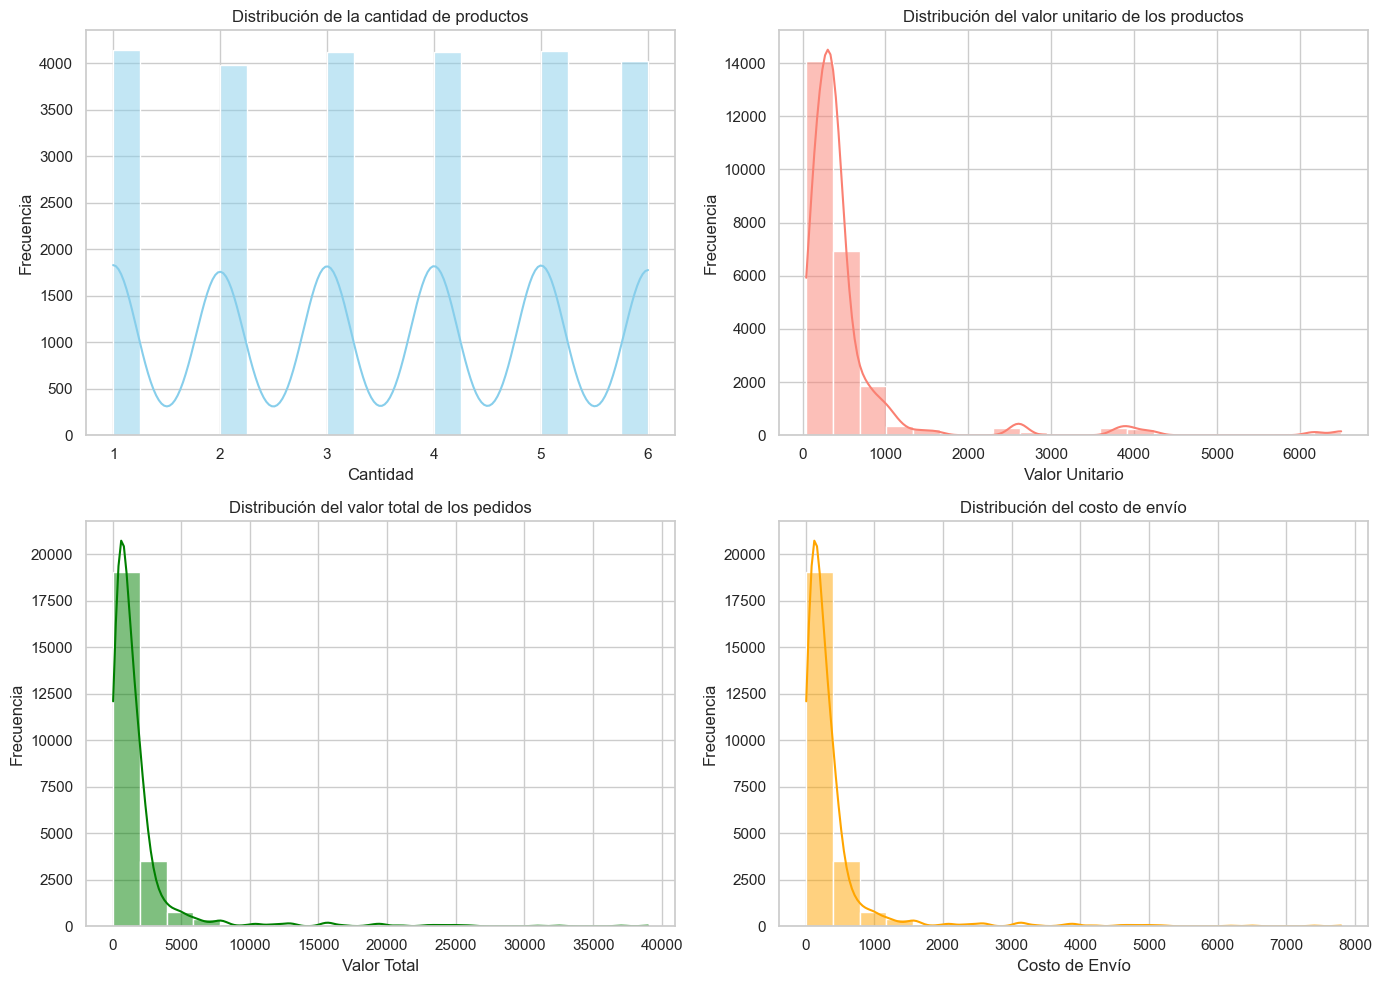

In [501]:
# Histogramas
warnings.filterwarnings("ignore", category=FutureWarning)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(items_pedidos_procesados['cantidad'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de la cantidad de productos')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(items_pedidos_procesados['valor_unitario'], bins=20, kde=True, color='salmon')
plt.title('Distribución del valor unitario de los productos')
plt.xlabel('Valor Unitario')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
sns.histplot(items_pedidos_procesados['valor_total'], bins=20, kde=True, color='green')
plt.title('Distribución del valor total de los pedidos')
plt.xlabel('Valor Total')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 4)
sns.histplot(items_pedidos_procesados['costo_envio'], bins=20, kde=True, color='orange')
plt.title('Distribución del costo de envío')
plt.xlabel('Costo de Envío')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


#### **Distribución de pedidos por cuidad**

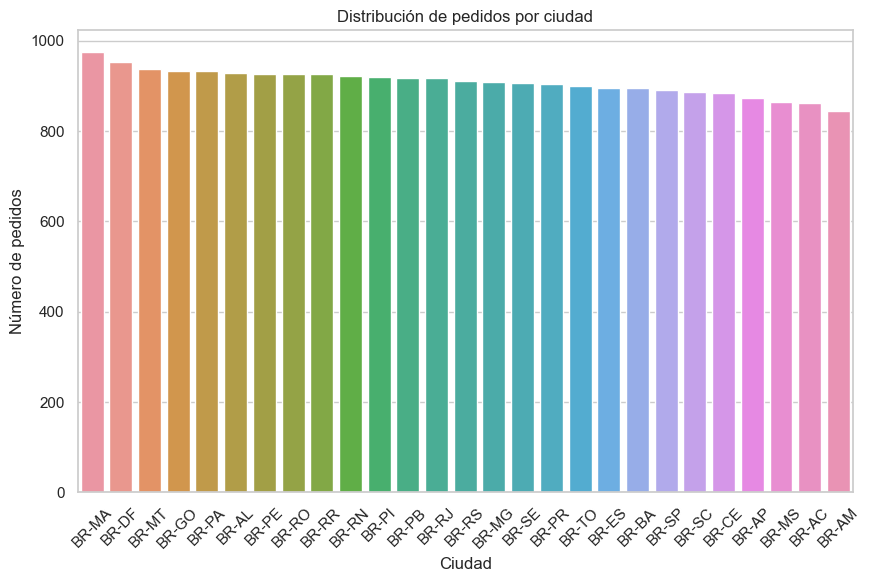

In [502]:
# Obtener el recuento de pedidos por ciudad y ordenar de mayor a menor
ciudades_ord = items_pedidos_procesados['ciudad'].value_counts().sort_values(ascending=False)

# Configuración de estilo
sns.set(style="whitegrid")

# Crear el gráfico de barras para los pedidos
plt.figure(figsize=(10, 6))
sns.barplot(x=ciudades_ord.index, y=ciudades_ord.values, order=ciudades_ord.index)
plt.title('Distribución de pedidos por ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de pedidos')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para una mejor visualización
plt.show()

#### **Diagrama de disperción (haciendo algunas pruebas)**

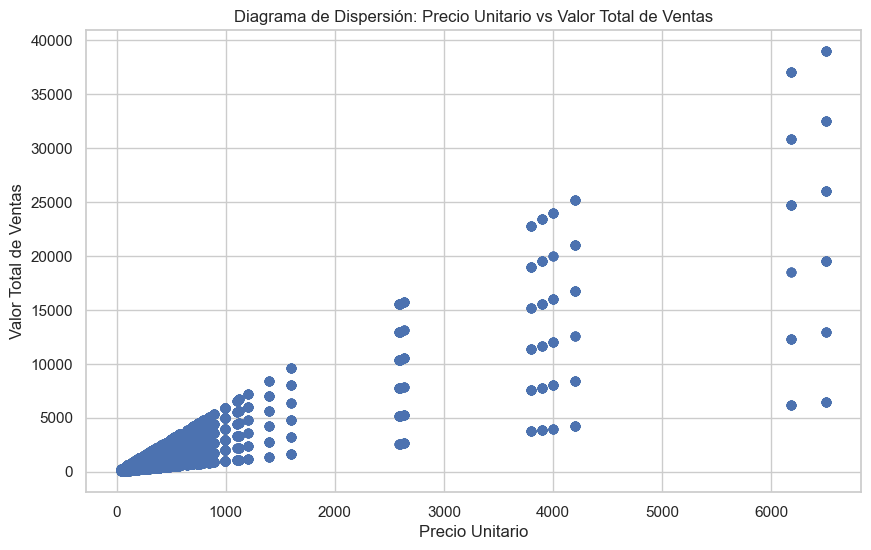

In [503]:
# Crear el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(items_pedidos_procesados['valor_unitario'], items_pedidos_procesados['valor_total'], alpha=0.5)
plt.title('Diagrama de Dispersión: Precio Unitario vs Valor Total de Ventas')
plt.xlabel('Precio Unitario')
plt.ylabel('Valor Total de Ventas')
plt.grid(True)
plt.show()

#### **Boxplots (aun en pruebas)**

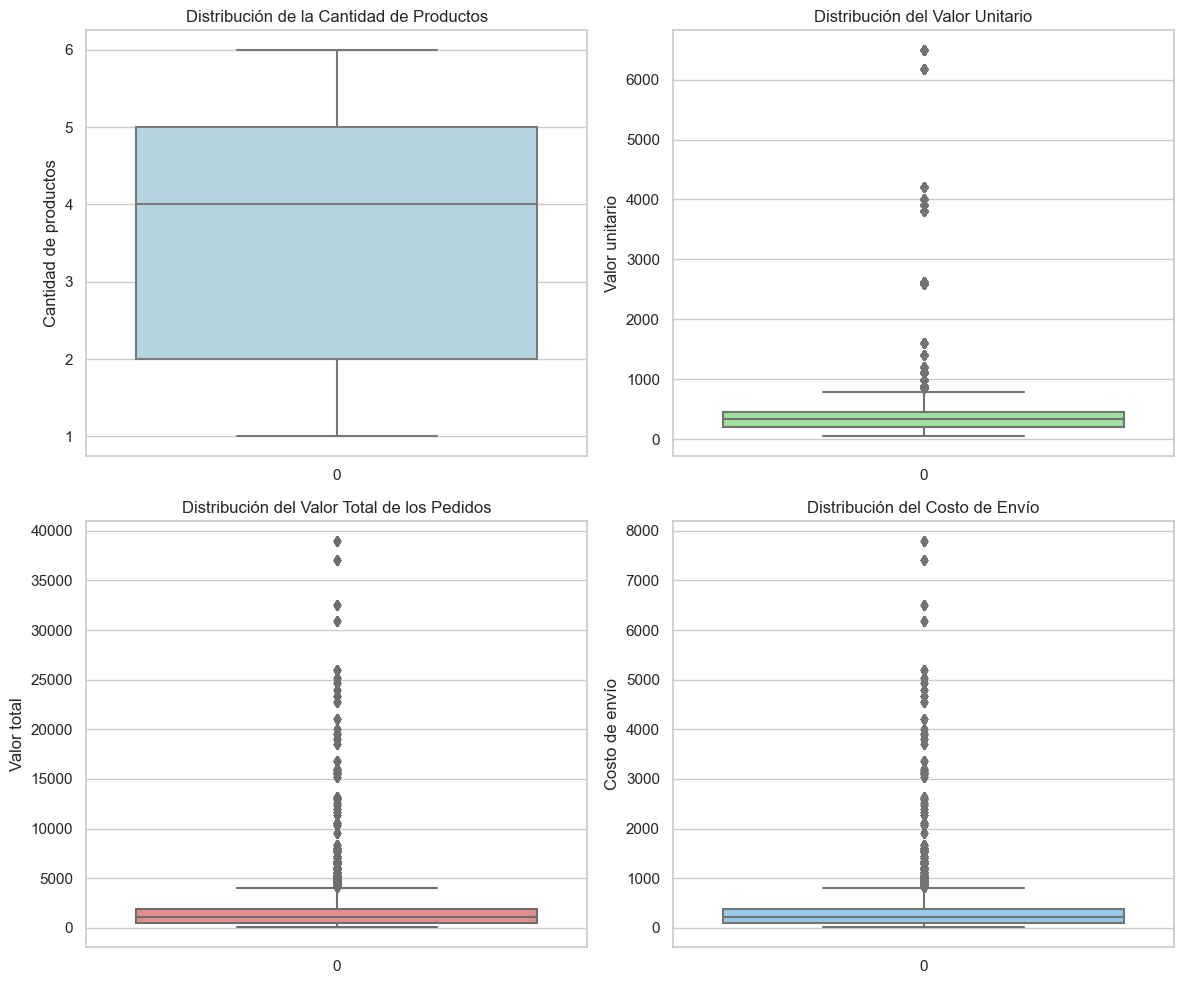

In [504]:
# Configuración de los estilos de Seaborn
sns.set(style="whitegrid")

# Crear una figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico de caja para la cantidad de productos en los pedidos
sns.boxplot(data=items_pedidos_procesados['cantidad'], color='lightblue', ax=axs[0, 0])
axs[0, 0].set_title('Distribución de la Cantidad de Productos')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Cantidad de productos')

# Gráfico de caja para el valor unitario de los productos
sns.boxplot(data=items_pedidos_procesados['valor_unitario'], color='lightgreen', ax=axs[0, 1])
axs[0, 1].set_title('Distribución del Valor Unitario')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Valor unitario')

# Gráfico de caja para el valor total de los pedidos
sns.boxplot(data=items_pedidos_procesados['valor_total'], color='lightcoral', ax=axs[1, 0])
axs[1, 0].set_title('Distribución del Valor Total de los Pedidos')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Valor total')

# Gráfico de caja para el costo de envío de los pedidos
sns.boxplot(data=items_pedidos_procesados['costo_envio'], color='lightskyblue', ax=axs[1, 1])
axs[1, 1].set_title('Distribución del Costo de Envío')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Costo de envío')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

### **2.3.2 pedidos**

In [505]:
print("Información y descripción del dataframe de pedidos:")
print(pedidos_procesados.info())
print(pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de pedidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int32         
 1   producto_id   24527 non-null  int32         
 2   vendedor_id   24527 non-null  int32         
 3   fecha_compra  24527 non-null  datetime64[ns]
 4   total         24527 non-null  int32         
dtypes: datetime64[ns](1), int32(4)
memory usage: 575.0 KB
None
           pedido_id    producto_id   vendedor_id  \
count   24527.000000   24527.000000  24527.000000   
mean    69931.383088   44627.641171      2.975782   
min         1.000000    2706.000000      1.000000   
25%     34487.000000   17258.000000      2.000000   
50%     69945.000000   42913.000000      3.000000   
75%    105355.000000   70673.000000      4.000000   
max    139993.000000  100983.000000      6.000000   
st

In [506]:
pedidos_procesados.sample(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
4819,122961,86302,5,2019-09-26,695
14493,53765,45695,4,2020-06-04,1200
14070,32651,83795,1,2020-05-18,1240
7323,89130,33976,4,2019-12-04,720
3329,13081,4853,5,2019-07-29,300


#### **Histograma**

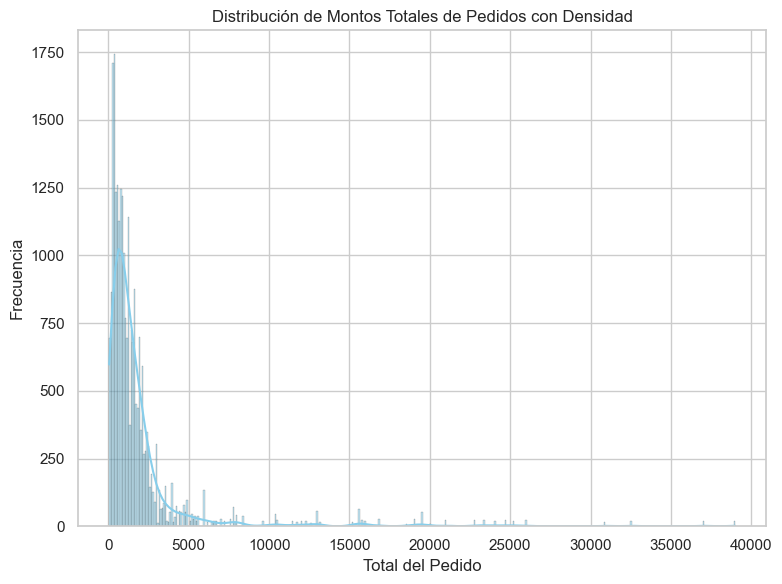

In [507]:
#Histograma de Total

plt.figure(figsize=(8, 6))
sns.histplot(pedidos_procesados['total'], kde=True, color='skyblue', edgecolor='black')
plt.title('Distribución de Montos Totales de Pedidos con Densidad')
plt.xlabel('Total del Pedido')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### **Pedidos por vendedor**

In [508]:
vendedores_procesados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vendedor_id      6 non-null      int32 
 1   nombre_vendedor  6 non-null      object
dtypes: int32(1), object(1)
memory usage: 200.0+ bytes


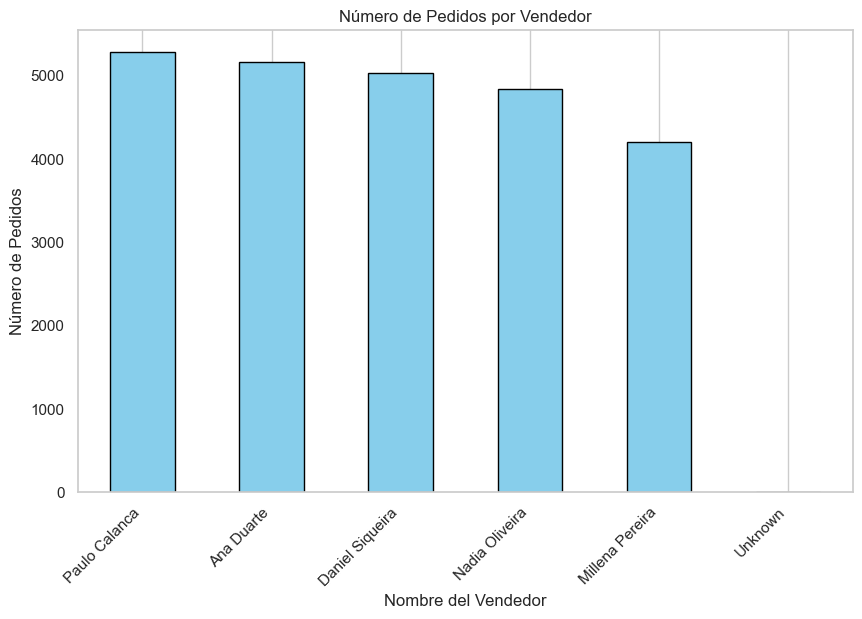

In [509]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [510]:
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


In [511]:
pedidos_procesados[pedidos_procesados['vendedor_id']==6]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780


In [512]:
fecha_inicio = "2019-01-01"
fecha_fin = "2019-02-01"
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


#### Tras una revisión exhaustiva, se identificó que el vendedor con ID 6 no está presente en el conjunto de datos de vendedores. Al realizar un análisis más detallado, se observó que este vendedor solo tiene un registro en el conjunto de datos de pedidos. Además, al buscar registros similares por fechas, no se encontraron coincidencias, lo que sugiere que su inclusión fue probablemente un error humano. Por lo tanto, se procederá a eliminar los datos relacionados con el vendedor 6 de la tabla de pedidos para garantizar la coherencia y la integridad de los datos.

In [513]:
vendedores_procesados = vendedores_procesados[vendedores_procesados["vendedor_id"] != 6]
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [514]:
pedidos_procesados = pedidos_procesados[pedidos_procesados["vendedor_id"] != 6]
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
5,2980,72621,1,2019-01-05,537
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


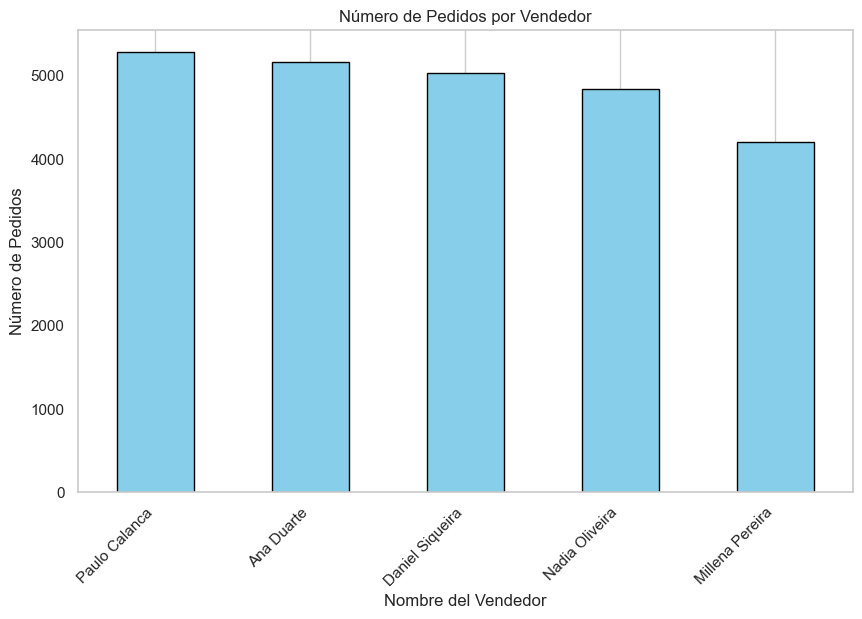

In [515]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

#### **Disperción fecha vs Total (pruebas)**

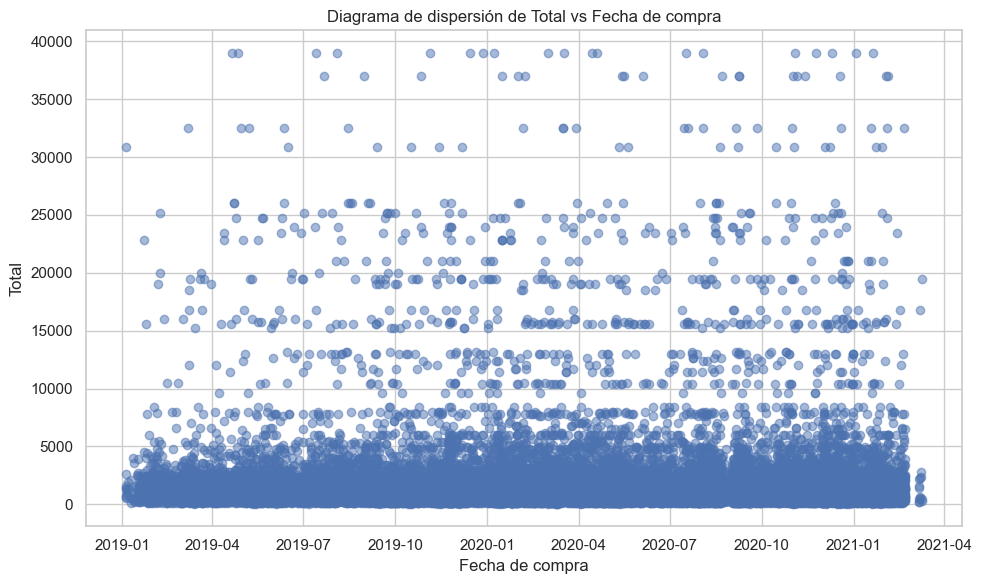

In [516]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pedidos_procesados['fecha_compra'], pedidos_procesados['total'], alpha=0.5)

# Añadir etiquetas y título
plt.title('Diagrama de dispersión de Total vs Fecha de compra')
plt.xlabel('Fecha de compra')
plt.ylabel('Total')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Ventas por año y mes (Group by Mount and Year)**

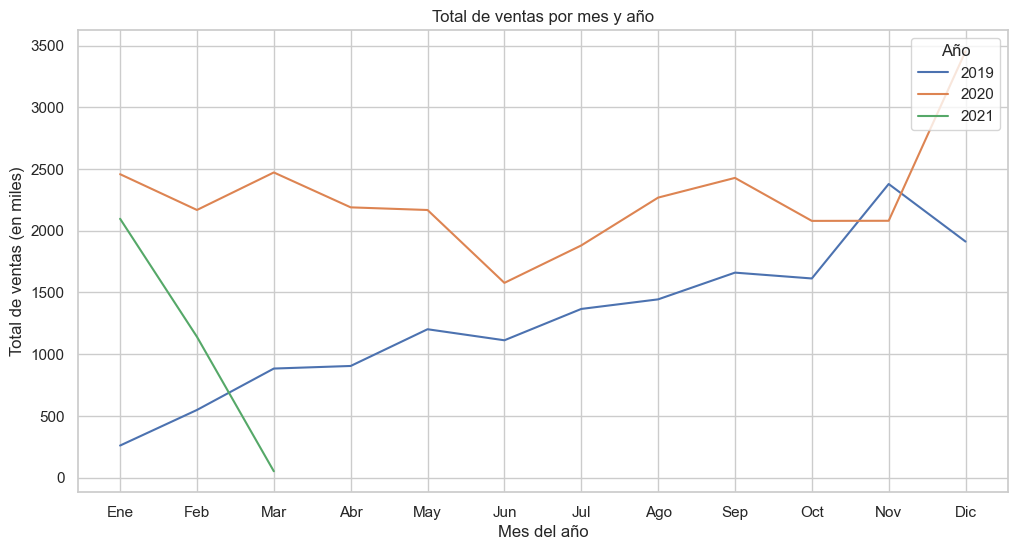

In [517]:
# Crear una nueva columna 'año' que represente el año en el que se realizó la compra
pedidos_procesados['año'] = pedidos_procesados['fecha_compra'].dt.year

# Crear una nueva columna 'mes' que represente el mes en el que se realizó la compra
pedidos_procesados['mes'] = pedidos_procesados['fecha_compra'].dt.month

# Agrupar los datos por año y mes y calcular el total de ventas para cada combinación
ventas_por_año_mes = pedidos_procesados.groupby(['año', 'mes'])['total'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
for año in ventas_por_año_mes['año'].unique():
    datos_año = ventas_por_año_mes[ventas_por_año_mes['año'] == año]
    plt.plot(datos_año['mes'], datos_año['total'] / 1000, label=str(año))

plt.xlabel('Mes del año')
plt.ylabel('Total de ventas (en miles)')
plt.title('Total de ventas por mes y año')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año', loc='upper right')
plt.grid(True)
plt.show()

#### **Boxplot**

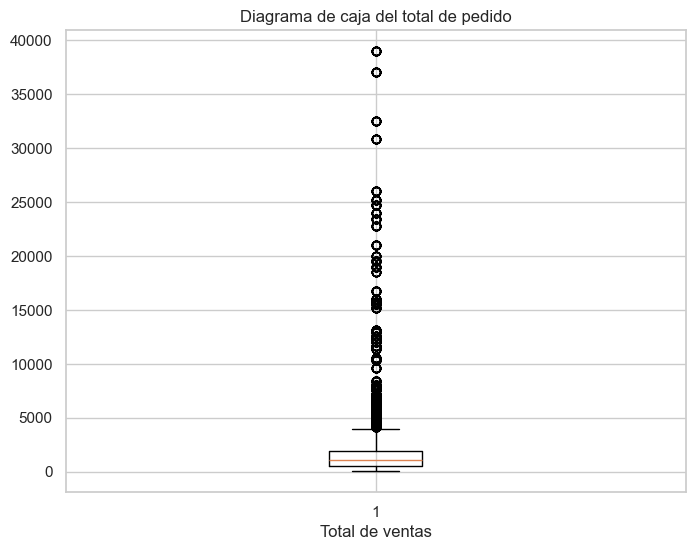

In [518]:
# Crear el diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot(pedidos_procesados['total'])

plt.xlabel('Total de ventas')
plt.title('Diagrama de caja del total de pedido')
plt.grid(True)
plt.show()

### **2.3.3 Productos**

In [519]:

print("Información y descripción del dataframe de productos:")
print(productos_procesados.info())
print(productos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de productos:
<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  205 non-null    int32  
 1   producto     205 non-null    object 
 2   precio       205 non-null    int32  
 3   marca        205 non-null    object 
 4   sku          205 non-null    float64
 5   condicion    205 non-null    object 
dtypes: float64(1), int32(2), object(3)
memory usage: 9.6+ KB
None
         producto_id       precio            sku
count     205.000000   205.000000     205.000000
mean    44803.365854   536.009756  304625.234146
std     29419.632374   843.774387  190141.444036
min      2706.000000    45.000000  101494.000000
25%     17329.000000   210.000000  222028.000000
50%     43054.000000   336.000000  263899.000000
75%     70673.000000   450.000000  304828.000000
max    100983.000000  6500.000000  952821.000000
---

In [520]:
print("Cantidad de productos unicos: ", productos_procesados['producto'].value_counts())

Cantidad de productos unicos:  producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Oculos Lente Azulada       1
                          ..
Shorts Listras Bordados    1
Saia Lurex Color           1
Body Estampa Coracoes      1
Peeptoe Preto Verniz       1
Calca Jeans Basica         1
Name: count, Length: 201, dtype: int64


In [521]:
print("Cantidad de productos unicos: ", productos_procesados['marca'].value_counts())

Cantidad de productos unicos:  marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     5
                   ..
Thay Ribas          1
Carter’s            1
American Eagle      1
Isolda              1
Express             1
Name: count, Length: 117, dtype: int64


In [522]:
print("Cantidad de productos unicos: ", productos_procesados['condicion'].value_counts())

Cantidad de productos unicos:  condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64


#### **Productos por condición**

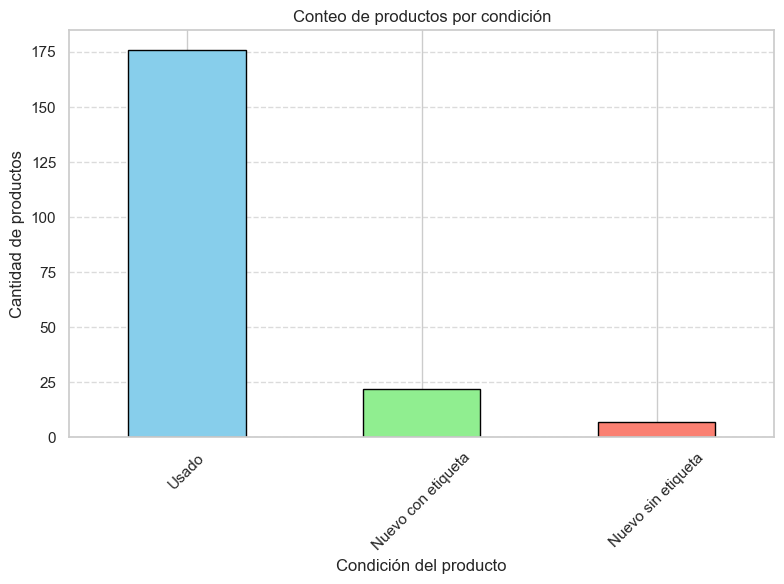

In [523]:
colors = ['skyblue', 'lightgreen', 'salmon']

# Crear un gráfico de barras para visualizar el conteo de productos por condición
plt.figure(figsize=(8, 6))
productos_procesados['condicion'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Conteo de productos por condición')
plt.xlabel('Condición del producto')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Boxplot de precios por condición**

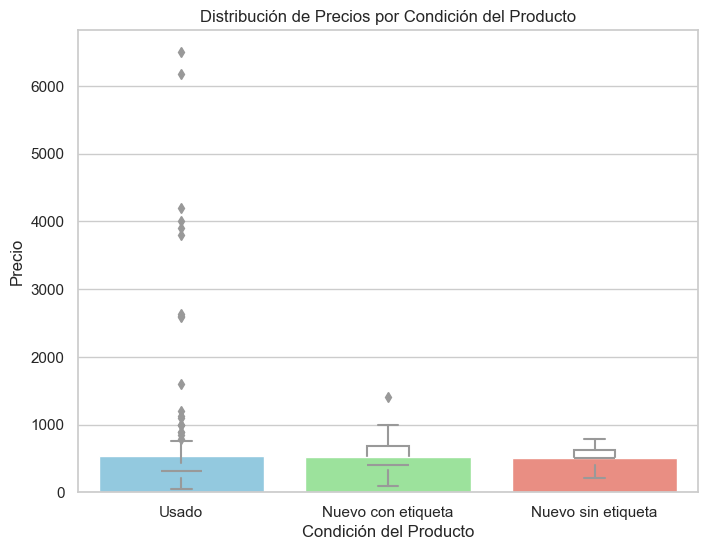

In [524]:
# Extraer los valores únicos de la columna 'condicion'
condiciones_unicas = productos_procesados['condicion'].unique()
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear el gráfico combinado de barras y diagrama de caja
plt.figure(figsize=(8, 6))
sns.barplot(x='condicion', y='precio', data=productos_procesados, palette=colores_condicion, ci=None)
sns.boxplot(x='condicion', y='precio', data=productos_procesados, color='white', width=0.2)

plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Condición del Producto')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

#### **Precios por Condición del Producto**

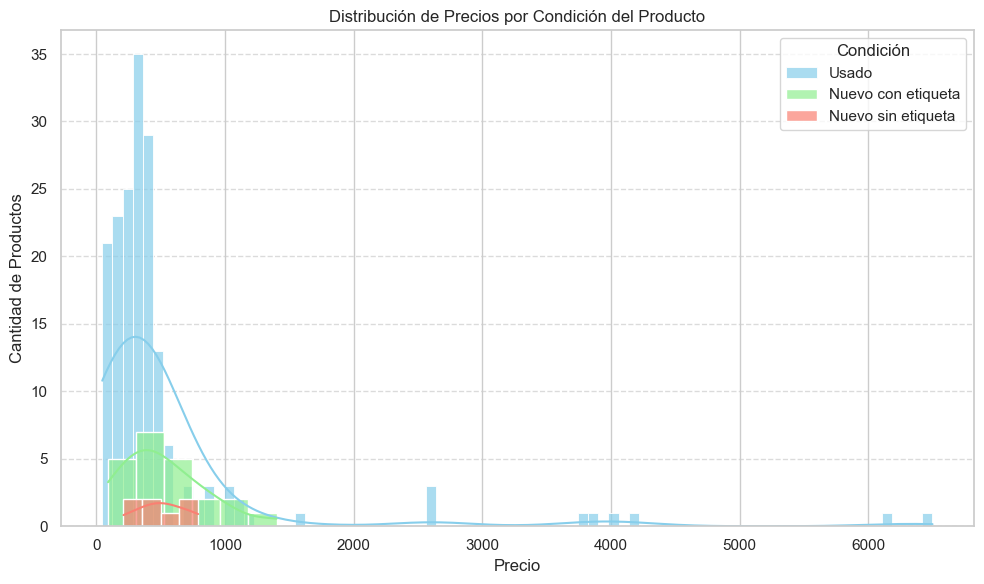

In [525]:
# Extraer los valores únicos de la columna de condición y eliminar espacios adicionales
condiciones_unicas = productos_procesados['condicion'].str.strip().unique()

# Crear un diccionario para mapear cada condición a un color
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear un gráfico de histograma para visualizar la distribución de precios por condición
plt.figure(figsize=(10, 6))
for condicion in condiciones_unicas:
    sns.histplot(data=productos_procesados[productos_procesados['condicion'].str.strip() == condicion], 
                 x='precio', color=colores_condicion[condicion], label=condicion, kde=True, alpha=0.7)
plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Productos')
plt.legend(title='Condición')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Disperción por marca y precio**

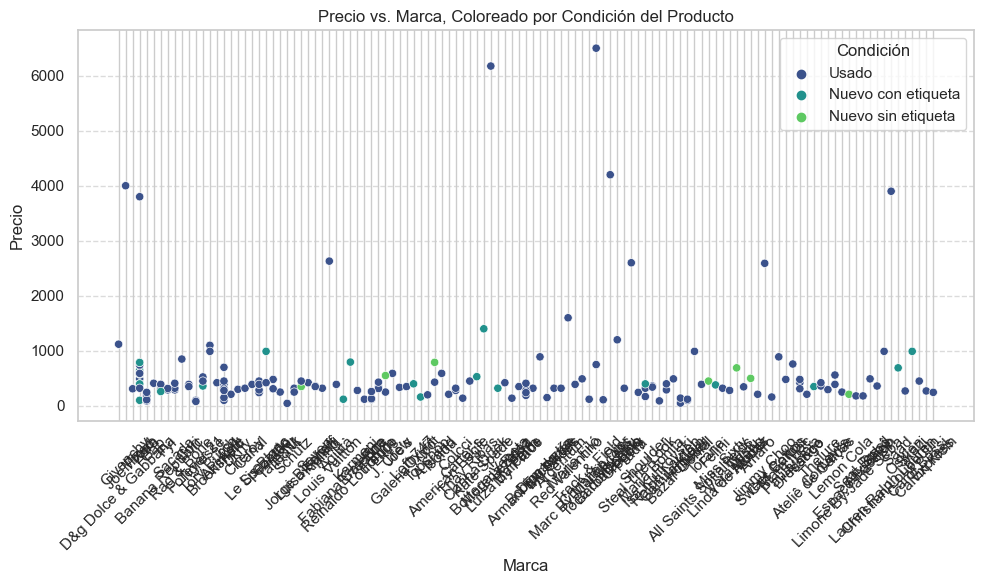

In [526]:
# Crear un gráfico de dispersión de precio vs. marca, coloreado por condición
plt.figure(figsize=(10, 6))
sns.scatterplot(data=productos_procesados, x='marca', y='precio', hue='condicion', palette='viridis')
plt.title('Precio vs. Marca, Coloreado por Condición del Producto')
plt.xlabel('Marca')
plt.ylabel('Precio')
plt.legend(title='Condición')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Este ultimo grafico no tiene sentido ni se porque lo hice XDXDXDXDXD

# **3 Banco de Datos**


---

In [527]:
print("items pedidos procesados")
print(items_pedidos_procesados.info())
print("pedidos_procesados")
print(pedidos_procesados.info())
print("pedidos_procesados")
print(productos_procesados.info())
print("vendedores_procesados")
print(vendedores_procesados.info())

items pedidos procesados
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int32  
 1   producto_id     24527 non-null  int32  
 2   pedido_id       24527 non-null  int32  
 3   cantidad        24527 non-null  int32  
 4   valor_unitario  24527 non-null  int32  
 5   valor_total     24527 non-null  int32  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 958.2+ KB
None
pedidos_procesados
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int32         
 1   producto_id   24526 non-null  int32         
 2   vendedor_id   24526 n

In [528]:
# Asignar los contenidos de los dataframes procesados a los dataframes originales
df_items_pedidos = items_pedidos_procesados.copy()
df_pedidos = pedidos_procesados.copy()
df_productos = productos_procesados.copy()
df_vendedores = vendedores_procesados.copy()

In [529]:
print("items pedidos ")
print(df_items_pedidos.info())
print("pedidos")
print(df_pedidos.info())
print("productos")
print(df_productos.info())
print("vendedores")
print(df_vendedores.info())

items pedidos 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int32  
 1   producto_id     24527 non-null  int32  
 2   pedido_id       24527 non-null  int32  
 3   cantidad        24527 non-null  int32  
 4   valor_unitario  24527 non-null  int32  
 5   valor_total     24527 non-null  int32  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 958.2+ KB
None
pedidos
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int32         
 1   producto_id   24526 non-null  int32         
 2   vendedor_id   24526 non-null  int32       

#### revisar items pedidos y pedidos

## **3.1 Levantando Motor**

In [530]:
# Definimos la función para crear la conexión y guardar los dataframes en una base de datos SQLite
def crear_conexion():
    # Creamos un engine de tipo SQLite
    engine = create_engine('sqlite:///database.db', echo=False)
    
    # Creamos un objeto MetaData
    metadata = MetaData()

    # Creamos manualmente las tablas en la base de datos
    items_pedidos_table = Table('items_pedidos', metadata,
                                 Column('id_recibo', Integer),
                                 Column('producto_id', Integer),
                                 Column('pedido_id', Integer),
                                 Column('cantidad', Integer),
                                 Column('valor_unitario', Integer),
                                 Column('valor_total', Integer),
                                 Column('ciudad', String),
                                 Column('costo_envio', Float)
                                )
    pedidos_table = Table('pedidos', metadata,
                           Column('pedido_id', Integer),
                           Column('producto_id', Integer),
                           Column('vendedor_id', Integer),
                           Column('fecha_compra', DateTime),
                           Column('total', Integer),
                           Column('año', Integer),
                           Column('mes', Integer)
                          )
    productos_table = Table('productos', metadata,
                             Column('producto_id', Integer),
                             Column('producto', String),
                             Column('precio', Integer),
                             Column('marca', String),
                             Column('sku', Float),
                             Column('condicion', String)
                            )
    vendedores_table = Table('vendedores', metadata,
                              Column('vendedor_id', Integer),
                              Column('nombre_vendedor', String)
                             )

    # Creamos las tablas en la base de datos
    metadata.create_all(engine)
    
    # Insertamos los datos de los dataframes en las tablas correspondientes
    df_items_pedidos.to_sql('items_pedidos', engine, if_exists='replace', index=False)
    df_pedidos.to_sql('pedidos', engine, if_exists='replace', index=False)
    df_productos.to_sql('productos', engine, if_exists='replace', index=False)
    df_vendedores.to_sql('vendedores', engine, if_exists='replace', index=False)



In [531]:
# Creamos un engine de tipo SQLite
engine = create_engine('sqlite:///database.db')

# Llamamos a la función para crear la conexión y guardar los dataframes en la base de datos
crear_conexion()

# Creamos un objeto Inspector para examinar la base de datos
inspector = inspect(engine)

# Obtenemos los nombres de las tablas en la base de datos
tabla_nombres = inspector.get_table_names()

# Imprimimos los nombres de las tablas
print("Nombres de las tablas en la base de datos:")
for tabla_nombre in tabla_nombres:
    print(tabla_nombre)

Nombres de las tablas en la base de datos:
items_pedidos
pedidos
productos
vendedores


In [556]:
# Creamos un engine de tipo SQLite
engine = create_engine('sqlite:///database.db')

# Obtenemos una conexión a la base de datos
connection = engine.connect()

# Creamos un objeto Text con la consulta SQL
consulta_sql = text("SELECT * FROM vendedores")

# Ejecutamos la consulta y obtenemos los resultados
resultados = connection.execute(consulta_sql)

# Imprimimos los resultados
for row in resultados:
    print(row)

# Cerramos la conexión
connection.close()

(1, 'Ana Duarte')
(2, 'Daniel Siqueira')
(3, 'Nadia Oliveira')
(4, 'Millena Pereira')
(5, 'Paulo Calanca')


# **4 ¿Cual es el Top 5 productos más vendidos históricamente?**


---

In [533]:
# Conectar a la base de datos
engine = create_engine('sqlite:///database.db')

# Crear una conexión y ejecutar la consulta SQL
with engine.connect() as connection:
    consulta_sql = text("""
        SELECT p.producto_id, p.producto, p.marca,
               SUM(i.cantidad) AS cantidad_vendida,
               SUM(i.cantidad * pr.precio) AS monto_total
        FROM productos p
        INNER JOIN items_pedidos i ON p.producto_id = i.producto_id
        INNER JOIN productos pr ON p.producto_id = pr.producto_id
        GROUP BY p.producto_id, p.producto, p.marca
        ORDER BY cantidad_vendida DESC
        LIMIT 5
    """)
    resultados = connection.execute(consulta_sql)

    # Guardar los resultados en un DataFrame
    df = pd.DataFrame(resultados, columns=['producto_id', 'producto', 'marca', 'cantidad_vendida', 'monto_total'])


In [534]:
df

,producto_id,producto,marca,cantidad_vendida,monto_total
0,32126,Saia Midi Cinto,Limone By Jade Seba,549,115290
1,13814,Vestido Nude Reta,Ellus,547,300850
2,47405,Blusa Manga Estampa,Animale,536,166160
3,33976,Camisa Xadrez Azul,Hollister,511,61320
4,53941,Cropped Escritas Pb,Linda de Morrer,508,142240


In [535]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   producto_id       5 non-null      int64 
 1   producto          5 non-null      object
 2   marca             5 non-null      object
 3   cantidad_vendida  5 non-null      int64 
 4   monto_total       5 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 328.0+ bytes


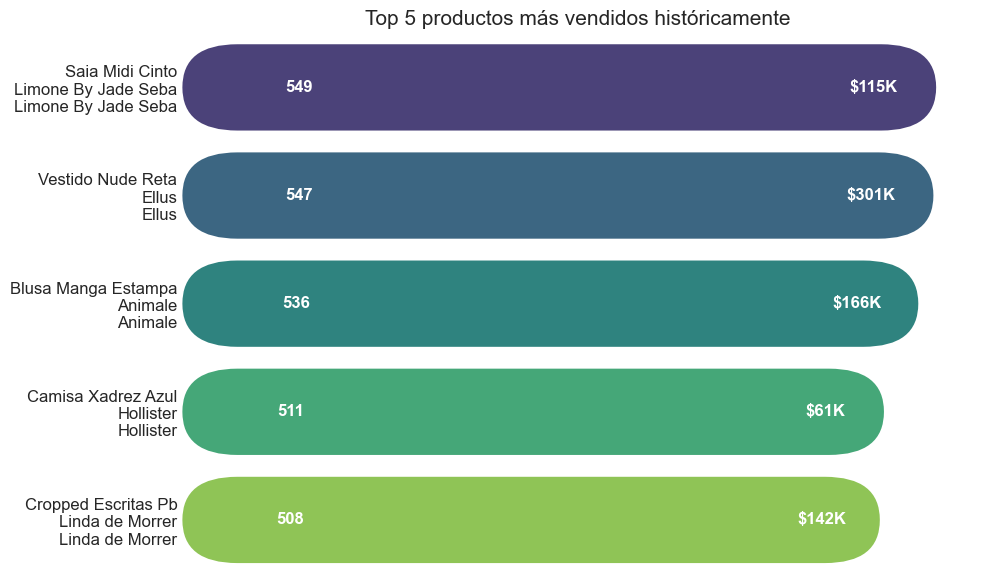

In [557]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Concatenar nombre y marca en una sola columna
#df['producto'] = df['producto'] + '\n' + df['marca']

# Crear el gráfico de barras con Seaborn y bordes redondeados
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, orient='h', palette='viridis', edgecolor='black')
sns.despine(left=True)  # Eliminar los bordes izquierdos
plt.title('Top 5 productos más vendidos históricamente', fontsize=15)
plt.ylabel('')  # Eliminar el texto del eje y
plt.xlabel('')  # Eliminar el texto del eje x
plt.grid(False)  # Eliminar la cuadrícula
plt.xticks([])  # Eliminar las marcas del eje x
plt.yticks(fontsize=12)  # Ajustar el tamaño de la fuente en el eje y

# Añadir números dentro de las barras (cantidad vendida en el lado izquierdo y monto total en el lado derecho)
for patch in ax.patches:
    width = patch.get_width()
    height = patch.get_height()
    x = patch.get_x() + width / 2
    y = patch.get_y() + height / 2
    cantidad_vendida = patch.get_width()
    monto_total = df[df['cantidad_vendida'] == cantidad_vendida]['monto_total'].values[0]
    ax.text(x - width / 2.9, y, f'{int(cantidad_vendida)}', ha='center', va='center', fontsize=12, color='white', weight='bold')
    ax.text(x + width / 2.4, y, f'${monto_total/1000:.0f}K', ha='center', va='center', fontsize=12, color='white', weight='bold')

new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.1000,rounding_size=40",  # Ajustar rounding_size
                            ec="none", fc=color,
                            mutation_aspect=0.01
                            )
    patch.remove()
    new_patches.append(p_bbox)

# Cargar la imagen de la blusa
imagen_path = 'blusa.png'
imagen = plt.imread(imagen_path)

# Ajustar el zoom según sea necesario
zoom_level = 0.8

# Iterar sobre cada barra en el gráfico
for patch in ax.patches:
    # Calcular la posición para colocar la imagen en la barra
    center_y = patch.get_y() + patch.get_height() / 2
    center_x = 1.35  # Posición horizontal ajustada según sea necesario

    # Crear un OffsetImage para la imagen de la blusa
    Imagebox = OffsetImage(imagen, zoom=zoom_level)

    # Añadir la imagen al gráfico en la posición correspondiente
    ab = AnnotationBbox(Imagebox, xy=(center_x, center_y),
                        xybox=(0, 0), xycoords='data', boxcoords='offset points',
                        pad=0, arrowprops=dict(arrowstyle='-', color='None'),
                        bboxprops=dict(facecolor='None', edgecolor='none'))

    ax.add_artist(ab)

for patch in new_patches:
    ax.add_patch(patch)

sns.despine(left=True, bottom=True)

ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()

# Eliminar la etiqueta del eje x 
ax.xaxis.label.set_visible(False)

plt.show()


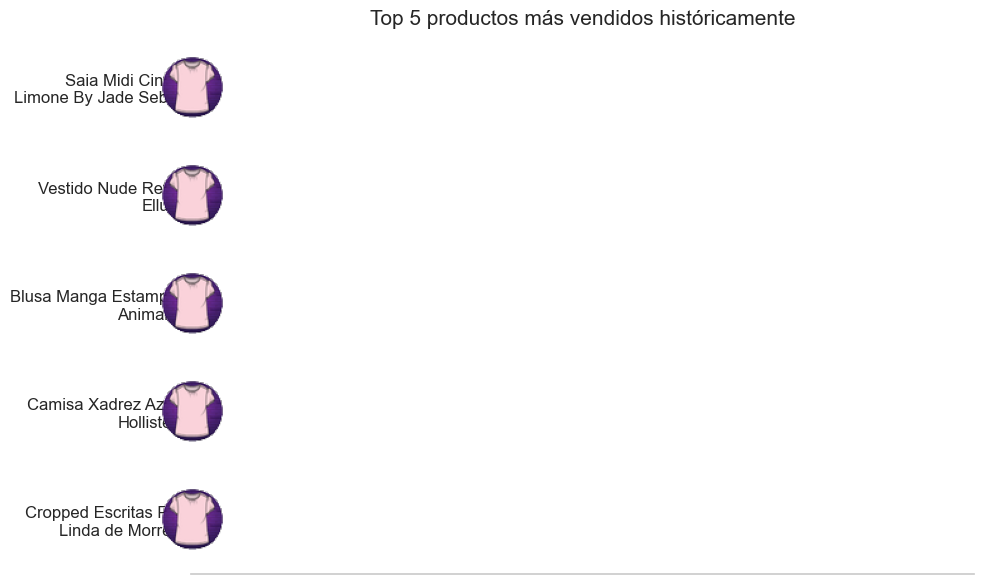

In [553]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Concatenar nombre y marca en una sola columna
#df['producto'] = df['producto'] + '\n' + df['marca']

# Crear el gráfico de barras con Seaborn y bordes redondeados
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, orient='h', palette='viridis', edgecolor='black')
sns.despine(left=True)  # Eliminar los bordes izquierdos
plt.title('Top 5 productos más vendidos históricamente', fontsize=15)
plt.ylabel('')  # Eliminar el texto del eje y
plt.xlabel('')  # Eliminar el texto del eje x
plt.grid(False)  # Eliminar la cuadrícula
plt.xticks([])  # Eliminar las marcas del eje x
plt.yticks(fontsize=12)  # Ajustar el tamaño de la fuente en el eje y

# Añadir números dentro de las barras (cantidad vendida en el lado izquierdo y monto total en el lado derecho)
for patch in ax.patches:
    width = patch.get_width()
    height = patch.get_height()
    x = patch.get_x() + width / 2
    y = patch.get_y() + height / 2
    cantidad_vendida = patch.get_width()
    monto_total = df[df['cantidad_vendida'] == cantidad_vendida]['monto_total'].values[0]
    ax.text(x - width / 2.4, y, f'{int(cantidad_vendida)}', ha='center', va='center', fontsize=12, color='white', weight='bold')
    ax.text(x + width / 2.4, y, f'${monto_total/1000:.0f}K', ha='center', va='center', fontsize=12, color='white', weight='bold')

# Cargar la imagen de la blusa
imagen_path = 'blusa.png'
imagen = plt.imread(imagen_path)

# Ajustar el zoom según sea necesario
zoom_level = 0.9

# Iterar sobre cada barra en el gráfico
for patch in ax.patches:
    # Calcular la posición para colocar la imagen en la barra
    center_y = patch.get_y() + patch.get_height() / 2
    center_x = 1.35  # Posición horizontal ajustada según sea necesario

    # Crear un OffsetImage para la imagen de la blusa
    Imagebox = OffsetImage(imagen, zoom=zoom_level)

    # Añadir la imagen al gráfico en la posición correspondiente
    ab = AnnotationBbox(Imagebox, xy=(center_x, center_y),
                        xybox=(0, 0), xycoords='data', boxcoords='offset points',
                        pad=0, arrowprops=dict(arrowstyle='-', color='None'),
                        bboxprops=dict(facecolor='None', edgecolor='none'))

    ax.add_artist(ab)
    

# Añadir números dentro de las barras (cantidad vendida en el lado izquierdo y monto total en el lado derecho)
for patch in ax.patches:
    width = patch.get_width()
    height = patch.get_height()
    x = patch.get_x() + width / 2
    y = patch.get_y() + height / 2
    cantidad_vendida = patch.get_width()
    monto_total = df[df['cantidad_vendida'] == cantidad_vendida]['monto_total'].values[0]
    ax.text(x - width / 2.9, y, f'{int(cantidad_vendida)}', ha='center', va='center', fontsize=12, color='white', weight='bold')
    ax.text(x + width / 2.4, y, f'${monto_total/1000:.0f}K', ha='center', va='center', fontsize=12, color='white', weight='bold')

new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.1000,rounding_size=40",  # Ajustar rounding_size
                            ec="none", fc=color,
                            mutation_aspect=0.01
                            )
    patch.remove()
    new_patches.append(p_bbox)


plt.tight_layout()

# Eliminar la etiqueta del eje x 
ax.xaxis.label.set_visible(False)

plt.show()